<a href="https://colab.research.google.com/github/Bookas1468/data-science-google-colab/blob/main/projects/LukaCookU4Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Social Media Usage by Country





In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

This here's the gosh dang data! It's somewhat gosh dang cool, and rather gosh dang long, at 704 entries. I've removed every country with less than 10 data points to get rid of any categories with too little data that would brick the model. The only columns we care about are country and average daily usage hours, but I'll keep the rest of them to look at.

I am predicting the daily usage hours of people based on the country they are from. I am predicting that most countries will have a mean that is generally similar for most of the people from that country. This is relevant because social media usage can be addictive and has a number of health and social detriments assosiated with it, so having a higher average amount in a country might result in broader effects.

In [155]:
addiction_data=pd.read_csv("https://raw.githubusercontent.com/Bookas1468/data-science-google-colab/refs/heads/main/projects/Students%20Social%20Media%20Addiction.csv")
countries = {}
for i in addiction_data.Country :
    countries.update({i:countries.get(i,0)+1})
for i in countries:
  if countries.get(i) <= 10:
    addiction_data=addiction_data.query('Country != "'+i+'"');
addiction_data

,Student_ID,Age,Gender,Academic_Level,Country,Avg_Daily_Usage_Hours,Most_Used_Platform,Affects_Academic_Performance,Sleep_Hours_Per_Night,Mental_Health_Score,Relationship_Status,Conflicts_Over_Social_Media,Addicted_Score
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,In Relationship,3,8
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,Single,0,3
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,Complicated,4,9
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,Single,1,4
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,In Relationship,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,701,20,Female,Undergraduate,Italy,4.7,TikTok,No,7.2,7,In Relationship,2,5
701,702,23,Male,Graduate,Russia,6.8,Instagram,Yes,5.9,4,Single,5,9
702,703,21,Female,Undergraduate,China,5.6,WeChat,Yes,6.7,6,In Relationship,3,7
703,704,24,Male,Graduate,Japan,4.3,Twitter,No,7.5,8,Single,2,4


Here we encode the data so that the computer can use it.

In [156]:
add_encode = pd.Categorical(addiction_data['Country'])
add_idx = add_encode.codes
print(type(add_idx))
add_coords = {"Country": add_encode.categories}

<class 'numpy.ndarray'>


In [157]:
add_coords

{'Country': Index(['Australia', 'Bangladesh', 'Canada', 'China', 'Denmark', 'France',
        'Germany', 'India', 'Ireland', 'Italy', 'Japan', 'Maldives', 'Mexico',
        'Nepal', 'Pakistan', 'Poland', 'Russia', 'South Korea', 'Spain',
        'Sri Lanka', 'Switzerland', 'Turkey', 'UK', 'USA'],
       dtype='object')}

This figure is a plot that demonstrates the distribution of average usage hours per country. As we can see some of them have significantly higher averages than others and most of them have a pretty good distribution.

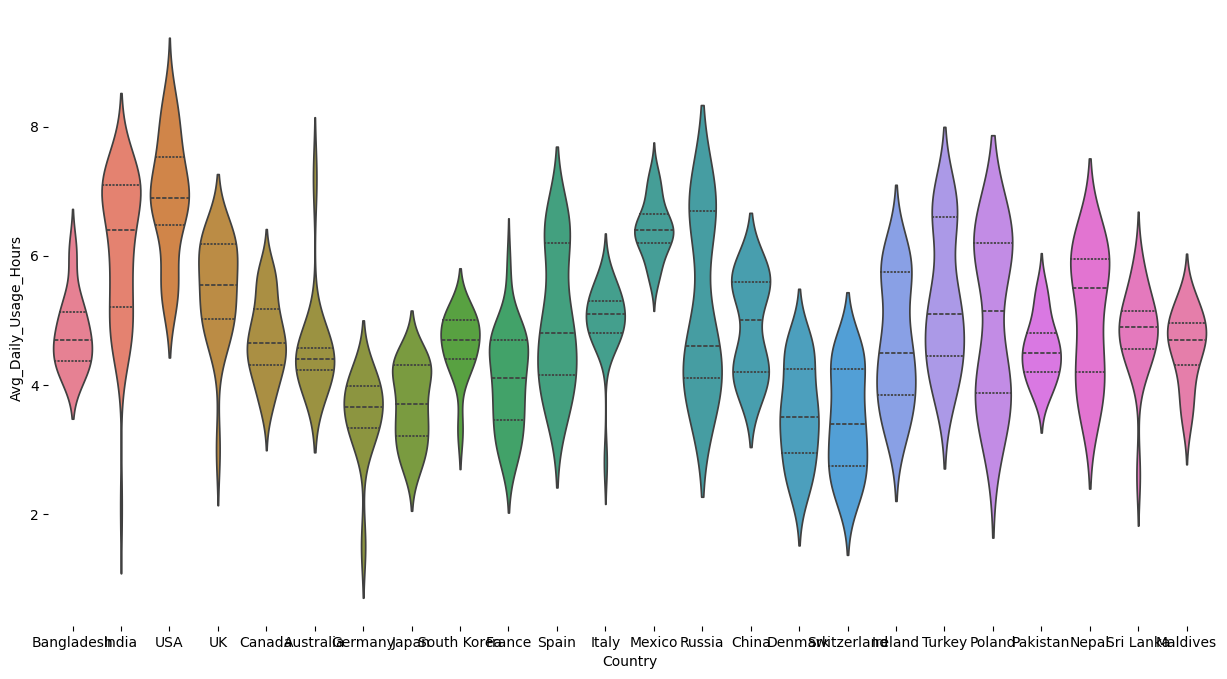

In [158]:
plt.figure(figsize=(15, 8)) # Increased figure size
sns.violinplot(addiction_data, x='Country', y='Avg_Daily_Usage_Hours', inner='quart',hue='Country')
sns.despine(top=True, right=True, bottom=True, left=True)

This makes the non-hierarachal model. I used a SkewStudentT because it fit the curve of the data pretty well, and I changed to it after having used a normal originally. After messing around with the priors I eventually settled on these values since they seem to fit the graph the best.

In [ ]:
with pm.Model(coords=add_coords) as add_nh_model:
    #priors
    #dims="aa" means to apply the prior seperately to each amino acid
    μ = pm.Normal('μ', mu=4, sigma=.25,
                  dims="Country")
    σ = pm.HalfNormal('σ', sigma=1,
                      dims="Country")

    #The idx variable tells my model which diffs belong to the same amino acid
    #this will cause my model to generate a posterior for each amino acid
    y = pm.SkewStudentT('y',
                  mu = μ[add_idx],
                  sigma = σ[add_idx], a=2,b=1,
                  observed=addiction_data.Avg_Daily_Usage_Hours)

    #cs for chemshift, nh for nonheirarchical
    idata_add_nh = pm.sample()

This here makes the heirarchal model, once again a skewstudentt. I'm using pretty much the same values, but slightly adapted since they're a hyperprior instead of just the regular prior.

In [ ]:
with pm.Model(coords=add_coords) as add_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 6, sigma = .25)
    μ_sd = pm.HalfNormal('μ_sd', sigma = .025)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu, # I include the hyperprior in my prior
                  sigma = μ_sd, # I include the hyperprior in my prior
                  dims = "Country")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "Country")

    #likelihood; same as before
    y = pm.SkewStudentT('y',
                  mu = μ[add_idx], #I include the prior in my likelihood
                  sigma = σ[add_idx], #I include the prior in my likelihood
                        a=2,b=1,
                  observed = addiction_data.Avg_Daily_Usage_Hours)

    #cs for chemshift, h for heirarchical
    idata_add_h = pm.sample()

Here we can see the distribution for both models in comparison to eachother. The median shown is about 4.4, which is very high considering that this is usage hours per day. that's almost 20 percent of the average day spent on social media. Interestingly, the hierarchical model's median is always higher than the non-hierarchical, indicating that the usage time per country may not be related to eachother directly.

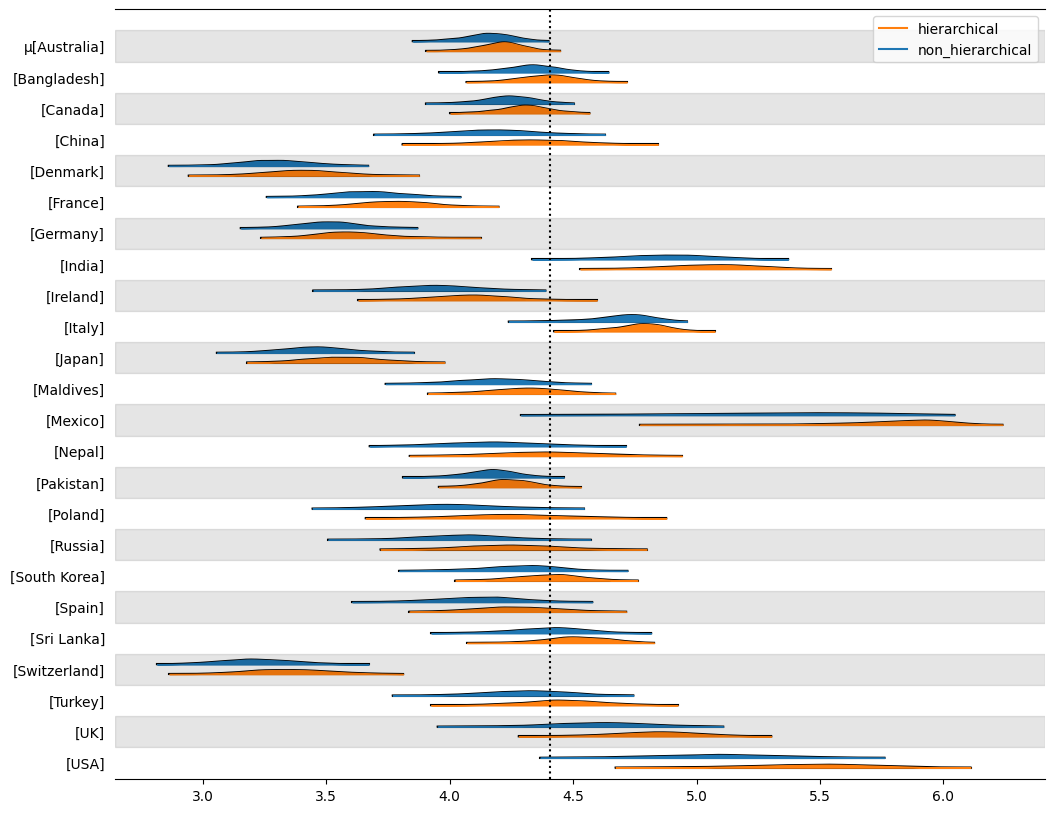

In [161]:
#plots a 99.7% hdi for the posteriors of both models on the same plot
axes = az.plot_forest([idata_add_nh, idata_add_h], kind="ridgeplot",
                      model_names=['non_hierarchical', 'hierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_add_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

In [ ]:
pm.sample_posterior_predictive(idata_add_h, model=add_h_model, extend_inferencedata=True)

In [ ]:
pm.sample_posterior_predictive(idata_add_nh, model=add_nh_model, extend_inferencedata=True)

here are the posteriors for both the heirarchical and non-heirarchical in that order. My model fits fairly well (ignore the posterior predictive mean it keeps breaking and isn't accurate), and the average looks very high. 4.4 is once again the most common point, but there are a lot of places past that that are fairly common too. If we took another country, I would expect it to be about 5.

This is probably much higher than it should be in reality. The dataset I found only includes people from the ages of roughly 18-25, who are by far the most likely to spend too much time on social media, and the sample size is nowhere near enough to make an accurate average for an entire country. Still, among these age groups, we can expect to see a lot more social media usage than is healthy.

<function matplotlib.pyplot.show(close=None, block=None)>

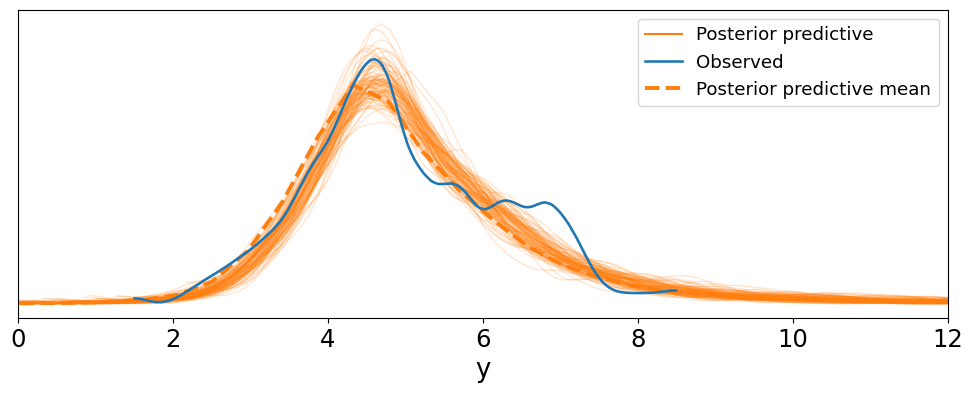

In [168]:
fig, ax = plt.subplots(figsize=(12,4))
az.plot_ppc(idata_add_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"],ax=ax)
ax.set_xlim(0,12)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

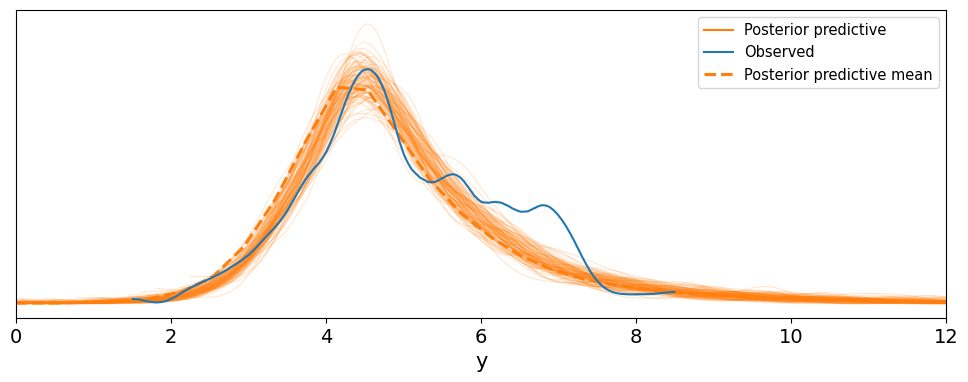

In [152]:
fig, ax = plt.subplots(figsize=(12,4))
az.plot_ppc(idata_add_nh, num_pp_samples=100, colors=["C1", "C0", "C1"], ax=ax)
ax.set_xlim(0,12)
plt.show